In [5]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [6]:
train_data = datasets.MNIST(
    root = "data",
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    transform = ToTensor(),
    download = True
)

In [13]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [14]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [15]:
from torch.utils.data import DataLoader

loaders = {

    'train' : DataLoader(train_data,
                         batch_size= 100,
                         shuffle = True,
                         num_workers=1),
    
    'test' : DataLoader(test_data,
                         batch_size= 100,
                         shuffle = True,
                         num_workers=1)


}

In [16]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f0394f62e00>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f0394f627d0>}

In [14]:
#Structure of NN

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(1,10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10,20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320,50)
        self.fc2 = nn.Linear(50,10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)) , 2))
        x = x.view(-1,320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)

        return F.softmax(x)

In [18]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(f'train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)}] ({100. * batch_idx / len(loaders["train"]):.0f}%)]\t{loss.item():.6f}')


def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim = True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Avg loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} 'f'({100. * correct / len(loaders["test"].dataset):.0f}%)\n')
 

cuda


In [19]:
for epoch in range(1,11):
    train(epoch)
    test()

/tmp/ipykernel_89614/3005187229.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


train Epoch: 1 [0/60000] (0%)]	2.302269
train Epoch: 1 [2000/60000] (3%)]	2.255672
train Epoch: 1 [4000/60000] (7%)]	2.132679
train Epoch: 1 [6000/60000] (10%)]	1.950798
train Epoch: 1 [8000/60000] (13%)]	1.876157
train Epoch: 1 [10000/60000] (17%)]	1.884224
train Epoch: 1 [12000/60000] (20%)]	1.785224
train Epoch: 1 [14000/60000] (23%)]	1.775683
train Epoch: 1 [16000/60000] (27%)]	1.737000
train Epoch: 1 [18000/60000] (30%)]	1.713992
train Epoch: 1 [20000/60000] (33%)]	1.765125
train Epoch: 1 [22000/60000] (37%)]	1.702411
train Epoch: 1 [24000/60000] (40%)]	1.657537
train Epoch: 1 [26000/60000] (43%)]	1.660797
train Epoch: 1 [28000/60000] (47%)]	1.668110
train Epoch: 1 [30000/60000] (50%)]	1.646352
train Epoch: 1 [32000/60000] (53%)]	1.676582
train Epoch: 1 [34000/60000] (57%)]	1.662540
train Epoch: 1 [36000/60000] (60%)]	1.673964
train Epoch: 1 [38000/60000] (63%)]	1.617643
train Epoch: 1 [40000/60000] (67%)]	1.579308
train Epoch: 1 [42000/60000] (70%)]	1.702323
train Epoch: 1 [44000

In [20]:
import torch

# Save the model
model_path = '/mnt/d/projects/MNISTdigits/models/mnist_cnn_model.pth'
torch.save(model.state_dict(), model_path)


cuda


/tmp/ipykernel_100673/3005187229.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


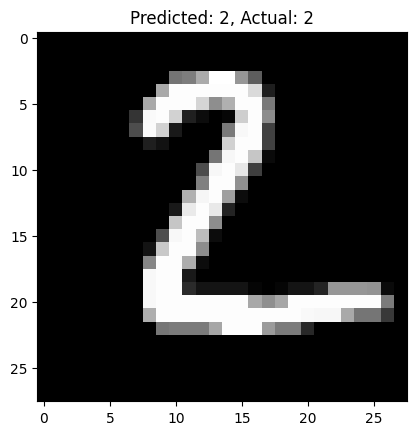

In [15]:
import matplotlib.pyplot as plt

# Load the model
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model = CNN().to(device)

model_path = '/mnt/d/projects/MNISTdigits/models/mnist_cnn_model.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

# Function to test a single image by index
def test_single_image(index):
    image, label = test_data[index]
    image = image.unsqueeze(0).to(device)  # Add batch dimension and move to device
    with torch.no_grad():
        output = model(image)
        pred_label = output.argmax(dim=1, keepdim=True).item()
    
    # Display the image
    plt.imshow(image.cpu().squeeze(), cmap='gray')
    plt.title(f'Predicted: {pred_label}, Actual: {label}')
    plt.show()

# Test the function with an example index
test_single_image(1)
